In [2]:
%pylab inline
import pandas as pd
import fastparquet 
import os,sys

Populating the interactive namespace from numpy and matplotlib


In [3]:
import lightgbm as lgb

In [4]:
if 0:
    sys.path.insert(0,os.getcwd()+"/../../src/main")
else:
    sys.path.insert(0, "/mnt/lanlep2019/src/main")
    os.environ['LOCAL']="/mnt/local"

In [5]:
!echo $LOCAL

/mnt/local


In [6]:
!mkdir -p $LOCAL/sandbox

In [7]:
HOME=os.environ['LOCAL']+"/sandbox"
os.chdir(HOME)
os.getcwd()

'/mnt/local/sandbox'

In [8]:
os.environ['LANLEP_HOME']=HOME

In [9]:
import data

In [24]:
if 0:
    !ls /home/lizhen09/lanlep2019/input/feat/*.parq | grep -v offset_.parq | xargs -L1  -IINPUT cp INPUT {HOME}/input/feat/
else:
    !cd {HOME}/input/feat/ && cat /mnt/lizhen-east2/notebook/fastseq/5/tmp.tar | tar xf - 
    !cd {HOME}/input/feat/ && cat /mnt/lizhen-east2/notebook/fastseq/5/tmppkl.tar | tar xf -     

In [10]:
reload (data)

<module 'data' from '/mnt/lanlep2019/src/main/data.pyc'>

In [11]:
if 1:
    strategy = {'type':'rand', "fold":5}
    types=['fwv']
    traintest = data.TrainTest('offset', offset=0, types=types, transform=None, valid_strategy=strategy)

In [12]:
traintest.num_dataset()

5

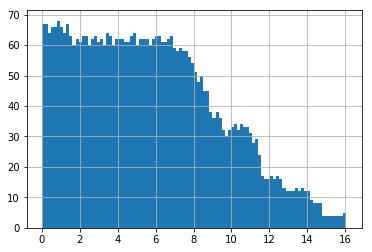

In [13]:
traintest.ydf.hist(bins=100);

In [14]:
np.abs(traintest.ydf-traintest.ydf.median()).mean()

3.032763197384022

In [15]:
testdf=traintest.get_test_data()
testdf.shape

(2624, 100)

In [16]:
datadf=pd.concat([traintest.traindf, traintest.ydf],axis=1)
print datadf.shape
datadf.head()

(4184, 101)


fwv_0     fwv_1     fwv_2     fwv_3     fwv_4     fwv_5  \
index                                                                       
quake_07_0405  0.177243  0.148722  0.101298 -0.151453  0.118340  0.085533   
quake_07_0404  0.175916  0.208865  0.121425 -0.149945  0.078927 -0.033455   
quake_07_0159  0.123625  0.259964  0.114662 -0.177983  0.076714 -0.008650   
quake_07_0158  0.127892  0.236912  0.120239 -0.147701  0.065033 -0.029501   
quake_07_0401  0.168152  0.240921  0.146662 -0.184900  0.126381  0.005611   

                  fwv_6     fwv_7     fwv_8     fwv_9    ...       fwv_91  \
index                                                    ...                
quake_07_0405 -0.126488  0.383367  0.184891 -0.182000    ...     0.276661   
quake_07_0404 -0.001732  0.259981  0.170118 -0.146734    ...     0.182124   
quake_07_0159  0.029887  0.234569  0.166675 -0.139920    ...     0.131131   
quake_07_0158  0.007605  0.238272  0.166551 -0.104213    ...     0.158076   
quake_07_0401  0.008869  0.288528  0.169460 -0.190870    ...     0.173906   

                 fwv_92    fwv_93    fwv_94    fwv_95    fwv_96    fwv_97  \
index                                                                       
quake_07_0405 -0.040588 -0.079376 -0.185854  0.031153  0.011661 -0.177359   
quake_07_0404  0.020085  0.007380 -0.045135  0.012951  0.022898 -0.136806   
quake_07_0159  0.068873  0.045272  0.115157  0.038833  0.072388 -0.109722   
quake_07_0158  0.011800  0.050090  0.066010  0.055765  0.051091 -0.113880   
quake_07_0401  0.000818  0.020374 -0.018780  0.006945  0.040418 -0.139294   

                 fwv_98    fwv_99         y  
index                                        
quake_07_0405  0.021507  0.143021  0.287999  
quake_07_0404  0.015471  0.179152  0.327298  
quake_07_0159 -0.035507  0.092227  9.873498  
quake_07_0158  0.000226  0.118060  9.912896  
quake_07_0401 -0.030202  0.189248  0.444397  

[5 rows x 101 columns]

In [17]:
datadf= datadf[~datadf.index.duplicated(keep='first')]
datadf.shape

(4184, 101)

In [18]:
ydf=traintest.ydf
ydf.head()

index
quake_07_0405    0.287999
quake_07_0404    0.327298
quake_07_0159    9.873498
quake_07_0158    9.912896
quake_07_0401    0.444397
Name: y, dtype: float64

In [19]:
qdf=pd.DataFrame(datadf.index.map(lambda u: u.split("_")[1]).astype(np.int8),index=datadf.index)
qdf.head()

index
index               
quake_07_0405      7
quake_07_0404      7
quake_07_0159      7
quake_07_0158      7
quake_07_0401      7

In [20]:
qdf=qdf[~qdf['index'].isin({0,16})]
datadf=datadf.loc[qdf.index]
ydf=datadf['y']
datadf=datadf.drop('y',axis=1)
qdf.shape,datadf.shape,ydf.shape

((4100, 1), (4100, 100), (4100,))

In [21]:
qdf['index'].value_counts().to_frame().sort_index().T

1    2    3    4    5    6    7    8    9    10   11   12   13   14  \
index  296  363  227  325  206  181  413  202  247  293  282  226  219  378   

        15  
index  242

In [22]:
qlen=qdf['index'].value_counts().to_dict()
str(qlen)

'{1: 296, 2: 363, 3: 227, 4: 325, 5: 206, 6: 181, 7: 413, 8: 202, 9: 247, 10: 293, 11: 282, 12: 226, 13: 219, 14: 378, 15: 242}'

In [23]:
quakes=set(qdf['index'])
quakes

{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15}

In [26]:
import utils
n_thread= utils.get_num_thread()
n_thread

15

In [29]:
def train_quake(qno,params,n_thread):
    assert(qno in quakes)
    print 'valid quake', qno
    teidx=qdf['index']==qno
    tridx=~teidx
    
    Xtr,ytr,Xte,yte=datadf[tridx],ydf[tridx],datadf[teidx],ydf[teidx],
    Xtr,ytr,Xte,yte=[u.values for u in [Xtr,ytr,Xte,yte]]
    print Xtr.shape,ytr.shape,Xte.shape,yte.shape
    model = lgb.LGBMRegressor(n_estimators = 15000, n_jobs = n_thread, **params)
    model.fit(Xtr, ytr, 
                    eval_set=[(Xtr, ytr), (Xte, yte)], eval_metric='mae',
                    verbose=50, early_stopping_rounds=200)
    return model.best_score_['valid_1']['l1'], model.best_iteration_

In [30]:
params = {'num_leaves': 54,
          #'min_data_in_leaf': 79,
          'objective': 'huber',
          'max_depth': -1,
          'learning_rate': 0.01,
          "boosting": "gbdt",
          "bagging_freq": 5,
          "bagging_fraction": 0.8126672064208567,
          "bagging_seed": 11,
          "metric": 'mae',
          "verbosity": -1,
          'reg_alpha': 0.1302650970728192,
          'reg_lambda': 0.3603427518866501
         }

In [31]:
validScores={}
for qno in quakes:
    s=train_quake(qno,params,n_thread)
    print "quake ", qno,s
    validScores[qno]=s

valid quake 1
(3804, 100) (3804,) (296, 100) (296,)
Training until validation scores don't improve for 200 rounds.
[50]	training's l1: 2.79458	valid_1's l1: 2.70427
[100]	training's l1: 2.59759	valid_1's l1: 2.55689
[150]	training's l1: 2.42191	valid_1's l1: 2.43222
[200]	training's l1: 2.26595	valid_1's l1: 2.32668
[250]	training's l1: 2.12922	valid_1's l1: 2.23682
[300]	training's l1: 2.00936	valid_1's l1: 2.16356
[350]	training's l1: 1.90664	valid_1's l1: 2.10543
[400]	training's l1: 1.81937	valid_1's l1: 2.0486
[450]	training's l1: 1.74514	valid_1's l1: 2.00238
[500]	training's l1: 1.6798	valid_1's l1: 1.96837
[550]	training's l1: 1.62258	valid_1's l1: 1.94085
[600]	training's l1: 1.57111	valid_1's l1: 1.92101
[650]	training's l1: 1.52291	valid_1's l1: 1.90293
[700]	training's l1: 1.47805	valid_1's l1: 1.88474
[750]	training's l1: 1.4351	valid_1's l1: 1.86953
[800]	training's l1: 1.39464	valid_1's l1: 1.85496
[850]	training's l1: 1.35562	valid_1's l1: 1.84348
[900]	training's l1: 1

[50]	training's l1: 2.76314	valid_1's l1: 3.04258
[100]	training's l1: 2.56199	valid_1's l1: 2.88666
[150]	training's l1: 2.38465	valid_1's l1: 2.76035
[200]	training's l1: 2.226	valid_1's l1: 2.65164
[250]	training's l1: 2.08917	valid_1's l1: 2.5597
[300]	training's l1: 1.96985	valid_1's l1: 2.48155
[350]	training's l1: 1.86645	valid_1's l1: 2.42554
[400]	training's l1: 1.77892	valid_1's l1: 2.38098
[450]	training's l1: 1.70387	valid_1's l1: 2.35656
[500]	training's l1: 1.63873	valid_1's l1: 2.34324
[550]	training's l1: 1.58234	valid_1's l1: 2.32909
[600]	training's l1: 1.53185	valid_1's l1: 2.32063
[650]	training's l1: 1.48488	valid_1's l1: 2.30721
[700]	training's l1: 1.4403	valid_1's l1: 2.3036
[750]	training's l1: 1.39869	valid_1's l1: 2.29719
[800]	training's l1: 1.35875	valid_1's l1: 2.28651
[850]	training's l1: 1.32064	valid_1's l1: 2.27832
[900]	training's l1: 1.28465	valid_1's l1: 2.27198
[950]	training's l1: 1.25014	valid_1's l1: 2.26211
[1000]	training's l1: 1.21579	valid_1

[1800]	training's l1: 0.635748	valid_1's l1: 3.81479
[1850]	training's l1: 0.616307	valid_1's l1: 3.81215
[1900]	training's l1: 0.598647	valid_1's l1: 3.80964
[1950]	training's l1: 0.581459	valid_1's l1: 3.80608
[2000]	training's l1: 0.563826	valid_1's l1: 3.80288
[2050]	training's l1: 0.546943	valid_1's l1: 3.7997
[2100]	training's l1: 0.530522	valid_1's l1: 3.79545
[2150]	training's l1: 0.513941	valid_1's l1: 3.79403
[2200]	training's l1: 0.49817	valid_1's l1: 3.79204
[2250]	training's l1: 0.483429	valid_1's l1: 3.78744
[2300]	training's l1: 0.469287	valid_1's l1: 3.78429
[2350]	training's l1: 0.455391	valid_1's l1: 3.78111
[2400]	training's l1: 0.441558	valid_1's l1: 3.77859
[2450]	training's l1: 0.427427	valid_1's l1: 3.77563
[2500]	training's l1: 0.414286	valid_1's l1: 3.77276
[2550]	training's l1: 0.401819	valid_1's l1: 3.7723
[2600]	training's l1: 0.388991	valid_1's l1: 3.76862
[2650]	training's l1: 0.37716	valid_1's l1: 3.76424
[2700]	training's l1: 0.365585	valid_1's l1: 3.761

[700]	training's l1: 1.50642	valid_1's l1: 1.42514
[750]	training's l1: 1.46258	valid_1's l1: 1.4098
[800]	training's l1: 1.4208	valid_1's l1: 1.39665
[850]	training's l1: 1.38174	valid_1's l1: 1.38144
[900]	training's l1: 1.34323	valid_1's l1: 1.37044
[950]	training's l1: 1.30726	valid_1's l1: 1.36071
[1000]	training's l1: 1.27163	valid_1's l1: 1.34926
[1050]	training's l1: 1.23795	valid_1's l1: 1.34005
[1100]	training's l1: 1.20617	valid_1's l1: 1.33312
[1150]	training's l1: 1.17502	valid_1's l1: 1.32684
[1200]	training's l1: 1.14427	valid_1's l1: 1.31943
[1250]	training's l1: 1.11373	valid_1's l1: 1.3148
[1300]	training's l1: 1.08472	valid_1's l1: 1.31013
[1350]	training's l1: 1.05685	valid_1's l1: 1.30321
[1400]	training's l1: 1.02897	valid_1's l1: 1.29765
[1450]	training's l1: 1.00188	valid_1's l1: 1.29151
[1500]	training's l1: 0.975286	valid_1's l1: 1.28561
[1550]	training's l1: 0.950011	valid_1's l1: 1.27884
[1600]	training's l1: 0.92479	valid_1's l1: 1.2764
[1650]	training's l1

[3400]	training's l1: 0.291186	valid_1's l1: 3.21448
[3450]	training's l1: 0.283358	valid_1's l1: 3.21254
[3500]	training's l1: 0.275486	valid_1's l1: 3.21446
[3550]	training's l1: 0.267755	valid_1's l1: 3.21374
[3600]	training's l1: 0.260077	valid_1's l1: 3.21386
[3650]	training's l1: 0.252596	valid_1's l1: 3.21463
Early stopping, best iteration is:
[3450]	training's l1: 0.283358	valid_1's l1: 3.21254
quake  14 (3.212540073554252, 3450)
valid quake 15
(3858, 100) (3858,) (242, 100) (242,)
Training until validation scores don't improve for 200 rounds.
[50]	training's l1: 2.82841	valid_1's l1: 2.25937
[100]	training's l1: 2.63509	valid_1's l1: 2.06821
[150]	training's l1: 2.46326	valid_1's l1: 1.90146
[200]	training's l1: 2.31049	valid_1's l1: 1.77144
[250]	training's l1: 2.17635	valid_1's l1: 1.65696
[300]	training's l1: 2.06067	valid_1's l1: 1.56688
[350]	training's l1: 1.95946	valid_1's l1: 1.49122
[400]	training's l1: 1.86951	valid_1's l1: 1.44481
[450]	training's l1: 1.79127	valid_

In [32]:
vdf=pd.DataFrame(validScores).T
vdf.columns=['score','round']
vdf['round']=vdf['round'].astype(np.int)
vdf['qlen']=vdf.index.map(lambda u: qlen[u])
vdf=vdf.sort_values('score')

In [37]:
vdf['score'].mean( ),vdf['score'].median( )

(1.9486632810075688, 1.64353492901863)

In [33]:
vdf

score  round  qlen
9   1.045297    761   247
3   1.206847    580   227
11  1.242356   2942   282
10  1.337367   3070   293
12  1.390566    550   226
15  1.417391    455   242
13  1.520665    504   219
1   1.643535   2780   296
5   2.050896    230   206
4   2.089727   4615   325
8   2.138582    191   202
6   2.414094    100   181
2   2.775312   3436   363
14  3.212540   3450   378
7   3.744775   3360   413

In [37]:
testpred=[]
for qno in quakes:
    print 'valid quake', qno
    teidx=qdf['index']==qno
    tridx=~teidx
    
    Xtr,ytr,Xte,yte=datadf[tridx],ydf[tridx],datadf[teidx],ydf[teidx],
    Xtr,ytr,Xte,yte=[u.values for u in [Xtr,ytr,Xte,yte]]
    print Xtr.shape,ytr.shape,Xte.shape,yte.shape

    
    model = lgb.LGBMRegressor(n_estimators = 50000, n_jobs = n_thread, **params)
    model.fit(Xtr, ytr, 
                    eval_set=[(Xtr, ytr), (Xte, yte)], eval_metric='mae',
                    verbose=50, early_stopping_rounds=200)
    a = model.predict(testdf.values,  num_iteration=model.best_iteration_)
    testpred.append(a)

valid quake 1
(3804, 100) (3804,) (296, 100) (296,)
Training until validation scores don't improve for 200 rounds.
[50]	training's l1: 2.79445	valid_1's l1: 2.70502
[100]	training's l1: 2.59844	valid_1's l1: 2.55373
[150]	training's l1: 2.42231	valid_1's l1: 2.42658
[200]	training's l1: 2.26738	valid_1's l1: 2.32564
[250]	training's l1: 2.12976	valid_1's l1: 2.23377
[300]	training's l1: 2.0105	valid_1's l1: 2.16027
[350]	training's l1: 1.90928	valid_1's l1: 2.09969
[400]	training's l1: 1.82225	valid_1's l1: 2.0449
[450]	training's l1: 1.74816	valid_1's l1: 1.9958
[500]	training's l1: 1.68289	valid_1's l1: 1.96095
[550]	training's l1: 1.62608	valid_1's l1: 1.93382
[600]	training's l1: 1.5743	valid_1's l1: 1.9072
[650]	training's l1: 1.52634	valid_1's l1: 1.88393
[700]	training's l1: 1.48171	valid_1's l1: 1.86408
[750]	training's l1: 1.4396	valid_1's l1: 1.85172
[800]	training's l1: 1.40034	valid_1's l1: 1.83944
[850]	training's l1: 1.36271	valid_1's l1: 1.82828
[900]	training's l1: 1.32

[3550]	training's l1: 0.277757	valid_1's l1: 2.77879
[3600]	training's l1: 0.269542	valid_1's l1: 2.7785
Early stopping, best iteration is:
[3433]	training's l1: 0.297018	valid_1's l1: 2.7764
valid quake 3
(3873, 100) (3873,) (227, 100) (227,)
Training until validation scores don't improve for 200 rounds.
[50]	training's l1: 2.83148	valid_1's l1: 2.17774
[100]	training's l1: 2.6398	valid_1's l1: 1.97265
[150]	training's l1: 2.46938	valid_1's l1: 1.7847
[200]	training's l1: 2.31915	valid_1's l1: 1.6278
[250]	training's l1: 2.18607	valid_1's l1: 1.49149
[300]	training's l1: 2.06807	valid_1's l1: 1.38776
[350]	training's l1: 1.96424	valid_1's l1: 1.31466
[400]	training's l1: 1.87351	valid_1's l1: 1.268
[450]	training's l1: 1.79478	valid_1's l1: 1.2388
[500]	training's l1: 1.726	valid_1's l1: 1.22038
[550]	training's l1: 1.66543	valid_1's l1: 1.21106
[600]	training's l1: 1.61044	valid_1's l1: 1.21025
[650]	training's l1: 1.55852	valid_1's l1: 1.22149
[700]	training's l1: 1.50986	valid_1's 

[1650]	training's l1: 0.695131	valid_1's l1: 3.81908
[1700]	training's l1: 0.674414	valid_1's l1: 3.81495
[1750]	training's l1: 0.65495	valid_1's l1: 3.8115
[1800]	training's l1: 0.635705	valid_1's l1: 3.80919
[1850]	training's l1: 0.617551	valid_1's l1: 3.8054
[1900]	training's l1: 0.598853	valid_1's l1: 3.80258
[1950]	training's l1: 0.580933	valid_1's l1: 3.80118
[2000]	training's l1: 0.563843	valid_1's l1: 3.79834
[2050]	training's l1: 0.546675	valid_1's l1: 3.79603
[2100]	training's l1: 0.530242	valid_1's l1: 3.79226
[2150]	training's l1: 0.514502	valid_1's l1: 3.7886
[2200]	training's l1: 0.498957	valid_1's l1: 3.78721
[2250]	training's l1: 0.483549	valid_1's l1: 3.78384
[2300]	training's l1: 0.468743	valid_1's l1: 3.78021
[2350]	training's l1: 0.454252	valid_1's l1: 3.77739
[2400]	training's l1: 0.440392	valid_1's l1: 3.7739
[2450]	training's l1: 0.426843	valid_1's l1: 3.77165
[2500]	training's l1: 0.413548	valid_1's l1: 3.76801
[2550]	training's l1: 0.400851	valid_1's l1: 3.767


[3450]	training's l1: 0.331205	valid_1's l1: 1.34421
[3500]	training's l1: 0.322029	valid_1's l1: 1.34465
[3550]	training's l1: 0.312528	valid_1's l1: 1.34421
[3600]	training's l1: 0.303939	valid_1's l1: 1.34289
[3650]	training's l1: 0.295373	valid_1's l1: 1.34285
[3700]	training's l1: 0.28698	valid_1's l1: 1.34336
[3750]	training's l1: 0.278957	valid_1's l1: 1.34335
[3800]	training's l1: 0.271525	valid_1's l1: 1.34344
Early stopping, best iteration is:
[3609]	training's l1: 0.302298	valid_1's l1: 1.34238
valid quake 11
(3818, 100) (3818,) (282, 100) (282,)
Training until validation scores don't improve for 200 rounds.
[50]	training's l1: 2.81036	valid_1's l1: 2.5303
[100]	training's l1: 2.61794	valid_1's l1: 2.33359
[150]	training's l1: 2.44494	valid_1's l1: 2.15525
[200]	training's l1: 2.29337	valid_1's l1: 2.01001
[250]	training's l1: 2.15838	valid_1's l1: 1.88208
[300]	training's l1: 2.04122	valid_1's l1: 1.77917
[350]	training's l1: 1.93859	valid_1's l1: 1.69126
[400]	training's l

[2700]	training's l1: 0.428672	valid_1's l1: 3.23585
[2750]	training's l1: 0.416338	valid_1's l1: 3.23451
[2800]	training's l1: 0.404649	valid_1's l1: 3.23343
[2850]	training's l1: 0.393084	valid_1's l1: 3.23348
[2900]	training's l1: 0.381692	valid_1's l1: 3.23194
[2950]	training's l1: 0.370865	valid_1's l1: 3.22963
[3000]	training's l1: 0.360726	valid_1's l1: 3.22962
[3050]	training's l1: 0.35083	valid_1's l1: 3.22833
[3100]	training's l1: 0.340956	valid_1's l1: 3.22695
[3150]	training's l1: 0.331551	valid_1's l1: 3.2272
[3200]	training's l1: 0.322189	valid_1's l1: 3.22702
[3250]	training's l1: 0.313669	valid_1's l1: 3.22574
[3300]	training's l1: 0.304777	valid_1's l1: 3.22522
[3350]	training's l1: 0.29629	valid_1's l1: 3.2256
[3400]	training's l1: 0.287925	valid_1's l1: 3.2254
[3450]	training's l1: 0.279883	valid_1's l1: 3.22332
[3500]	training's l1: 0.272223	valid_1's l1: 3.22199
[3550]	training's l1: 0.264699	valid_1's l1: 3.22169
[3600]	training's l1: 0.257644	valid_1's l1: 3.2215

array([4.7707014 , 5.35075203, 3.59466908, ..., 7.57128456, 5.7775509 ,
       5.56328883])

5.6549714724261975 5.289914726849822


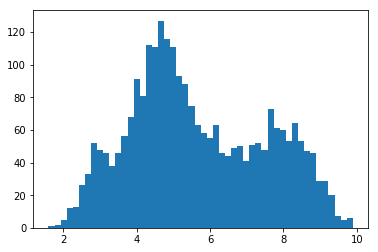

In [40]:
pred = reduce(lambda u,v: u+v, testpred)/len(testpred)
print np.mean(pred),np.median(pred)
plt.hist(pred,bins=50);

In [41]:
a=pd.DataFrame(pred,index=testdf.index).reset_index()
a.columns=["seg_id","time_to_failure"]
a.shape

(2624, 2)

5.581390091099076 5.317508264617578


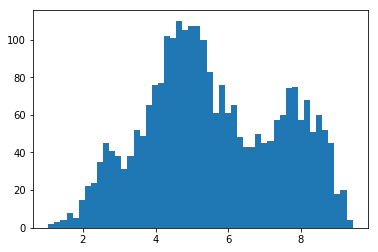

In [54]:
pred = np.median(np.array(testpred).T,1)
print np.mean(pred),np.median(pred)
plt.hist(pred,bins=50);

In [55]:
a=pd.DataFrame(pred,index=testdf.index).reset_index()
a.columns=["seg_id","time_to_failure"]
print a.shape
a.to_csv(os.environ['LOCAL']+"/input/sub/test_fwv_nonovp_qfold_lgb_median.csv",index=None)

(2624, 2)
